<a href="https://colab.research.google.com/github/weinberz/mixed_pop/blob/main/Puffs_Gaussian_Mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Molecular Marker for Puffs?

As part of discerning whether different cargoes have different recycling behaviors, we were interested in whether subsets of events are marked by specific molecular markers. Many aspects of vesicular traffic are well understood, so we looked to this knowledge to drive our exploration.

As there are a variety of compartments inside the cell, it is important to provide a mechanism for targetinig specificity. This specifity is thought to come through a variety of components, one set of which is called SNAREs. SNAREs come in two varieties:

* vSNAREs, which reside on cargo-containing __*V*__esicles
* tSNAREs, which reside in the __*T*__arget compartment (e.g. outer membrane, Golgi apparatus, endoplasmic reticulum)

Specificity is achieved through SNAREs because vSNAREs will specifically interact with their cognate tSNAREs. There are only a handful of vSNAREs that are known to target vesicles to the cellular limiting membrane (the membrane where our puffs are being delivered). Based on this, we started by looking through these SNAREs (named VAMP2, VAMP3, VAMP7, and VAMP8). The first one we had success with is VAMP2, the results of which are described below.


In [1]:
import numpy as np
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.utils import resample

import seaborn as sns

import io

import matplotlib.pyplot as plt

sns.set_palette(sns.color_palette(['black','#FF286E', '#008587']))

Hao manually identified as many puffs a possible in the two color movies we collected, only searching in the cargo channel to find puffs. For each identified puff, he then calculated an enrichment score for VAMP2:
  
$encrichment = \frac{F_{p} - \bar{F}_{b}}{SD_{b}}$


Where:


* $F_{p}$ is the bleedthrough corrected fluorescence value of the VAMP2 channel in the second frame of the puff (around where the puff fluorescence peaks).
* $\bar{F}_{b}$ is the mean fluorescence in the VAMP2 channel in the 5 frames before the puff's appearance
* $SD_{b}$ is the standard deviation of $\bar{F}_{b}$


Of the puffs Hao collected, we excluded two extreme outliers (enrichment >= 55).


In [2]:
#@title Run this cell to load data. Edit it to change data
# encoding Hao's data from a string
enrichment = """TfR,B2AR,MOR
1.507787544,3.110493843,3.929671906
0.242016519,1.905938919,10.546112180
2.497131875,6.939644641,6.647240486
0.781991090,-0.387322409,5.003538864
0.599159432,0.235993859,5.233121655
1.940827655,-0.499064320,5.927981978
-0.426773010,4.795904875,0.099131368
0.995531084,0.231234848,6.474119271
3.045811940,-0.820616410,2.498142458
-0.288802717,0.156332772,7.608996283
0.687618203,0.763278685,4.656684023
0.919490693,-0.607000336,1.044070209
1.627701698,6.336283302,6.865784260
3.892897530,-0.011397067,4.758399407
-0.956407120,3.797580218,8.723890030
-0.107430072,3.311592070,8.395598240
-2.187157706,0.463350067,3.097027850
-1.609817216,-1.726601429,5.890223347
-4.406600036,1.451267361,3.332051618
-2.018370658,27.506432920,3.735606665
-0.536123120,0.080283771,-0.118014490
0.788468311,7.309747532,3.657929744
-1.185811729,-1.437066809,1.152184595
-2.796886128,-1.848516559,7.023454849
-1.348902979,11.130870110,4.514208183
5.562947938,0.772853564,1.421018361
-1.130245518,-2.595459581,3.297129852
-2.241684751,-0.492674417,6.967803227
3.267917845,7.107137947,7.638420195
-4.609335465,0.306439802,
0.104021226,-2.007759287,0.325092519
-2.407735896,-1.703290430,-1.366221982
-0.010510538,-1.508325471,1.187289508
-0.815563645,1.568259994,4.939021064
-2.610025646,1.762751747,7.719553297
-2.555765588,1.413609798,0.708130843
-1.027440880,-0.111532302,1.275942918
-1.673998765,-1.063630570,-0.348665863
4.357596041,-1.467710911,3.605076905
-1.411923287,-0.426303069,6.335927958
-0.671121048,2.461056479,2.135987691
2.795784071,2.975980683,4.021451031
-8.451737548,-0.507117250,0.507391692
0.475256136,-0.016914169,5.541720043
7.968128115,-2.131220508,7.386083173
0.350657677,-0.784317408,6.130581508
7.226491673,0.259771024,3.761762819
-5.782091962,1.514887231,0.022318758
0.344152096,-0.187711604,0.653870912
3.243326987,-0.364760822,5.982387521
8.911295222,-0.037351846,2.413700329
9.048012019,3.387503423,7.692253809
4.910362520,-1.460019758,27.555889070
13.919595460,-3.981463874,36.418016060
-4.278973769,1.789975919,21.023961320
2.868040020,-2.272710080,0.712644831
-4.059560270,1.376458735,5.391466275
-2.792345438,-1.698119206,1.314681652
0.545958273,-3.538410016,11.223869370
1.981252299,-0.550556785,
7.098713776,0.365078201,
-6.381867283,0.209741011,
-2.682729571,0.451583084,
9.975316393,-0.984561685,
0.822349319,-2.448625925,
-2.231913399,1.910505411,
,3.337025987,
-0.726591826,1.490465267,
-0.871880053,5.643911376,
-2.547443209,-3.202983514,
-3.256889846,1.203492566,
-0.246539276,-3.462109761,
1.681263220,0.327339839,
-0.828266885,0.749027285,
9.280495113,-2.025578951,
24.917847880,-1.270454207,
-1.152895157,1.405365860,
3.324455660,-0.902474500,
-2.042121667,2.134086996,
-1.376194061,-1.108507589,
2.574754233,18.136583480,
-2.804702646,0.225062404,
15.088092810,2.132698842,
4.862693042,1.347060220,
0.198125022,-0.879995667,"""

In [3]:
puffs = pd.read_csv(io.StringIO(enrichment)).melt(value_vars=['TfR','B2AR','MOR'],var_name='cargo',value_name='enrichment').dropna()
puffs.head()

,cargo,enrichment
0,TfR,1.507788
1,TfR,0.242017
2,TfR,2.497132
3,TfR,0.781991
4,TfR,0.599159


The distribution of enrichment varies between receptors:


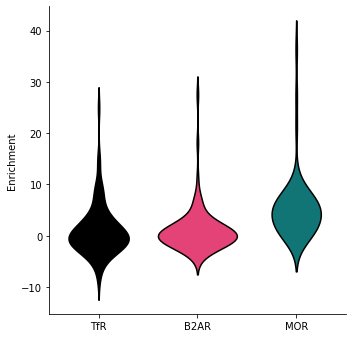

In [4]:
sns.catplot(x='cargo',y='enrichment', data=puffs, kind='violin', inner=None)
plt.ylabel('Enrichment')
plt.xlabel('')
plt.show()

Looking at a kernel density estimation, it's possible these populations are a mix of several gaussian distributions in the data, with at least one whose mean is ~0 and another whose mean is ~7


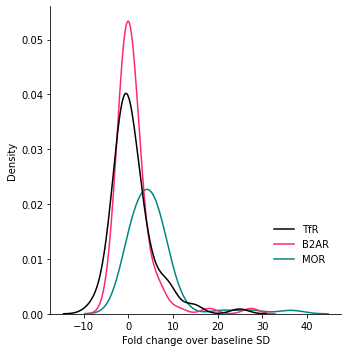

In [5]:
g = sns.displot(data=puffs, x='enrichment', kind='kde', hue='cargo')

plt.ylabel('Density')
plt.xlabel('Fold change over baseline SD')
sns.move_legend(g, loc='center right',title=None, frameon=False, bbox_to_anchor=[0.8, 0.3])
plt.show()

Why do we think these populations are mixtures? To understand this, lets imagine two populations, one with a mean of 5 and one with a mean of 3 (both normally distributed with an SD = 1):


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


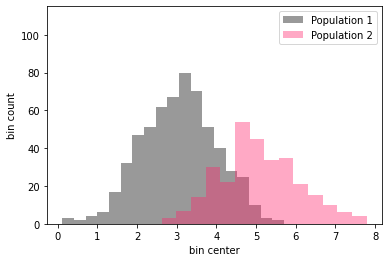

In [6]:
np.random.seed(4)
little_pop = np.random.normal(loc=5, size=300)
big_pop = np.random.normal(loc=3, size=600)
sns.distplot(big_pop, norm_hist = False, kde = False, label='Population 1')
sns.distplot(little_pop, norm_hist = False, kde = False, label = 'Population 2')
plt.xlabel('bin center')
plt.ylabel('bin count')
plt.ylim([0,115])
plt.legend()
plt.show()

When the populations are displayed independently, it's easy to tell them apart. But if we were instead to draw data from a set of samples that contained representatives from both populations, they'd be much hard to see:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


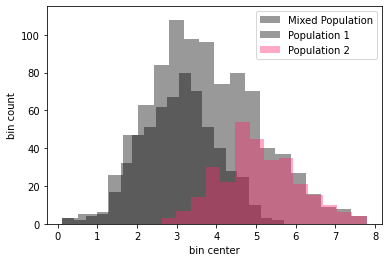

In [7]:
sns.distplot(np.hstack((big_pop,little_pop)), norm_hist = False, kde = False, label = 'Mixed Population', color='black')
sns.distplot(big_pop, norm_hist = False, kde = False, label='Population 1')
sns.distplot(little_pop, norm_hist = False, kde = False, label = 'Population 2')
plt.xlabel('bin center')
plt.ylabel('bin count')
plt.ylim([0,115])
plt.legend()
plt.show()

Using our sample X, which is the enrichment detected across our entire population, we fit Gaussian mixture models with between 1 and 9 components. We then use the AIC and BIC loss metrics to indicate which number of components minimizes loss in these models (look for the lowest point in the AIC and BIC curves below).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


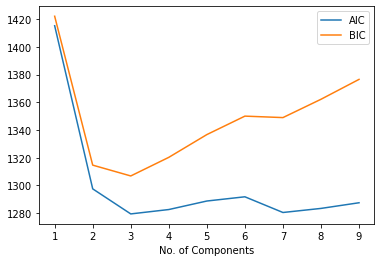

In [8]:
X = puffs.loc[:,'enrichment'][:,np.newaxis]
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i], covariance_type='spherical').fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

with sns.color_palette('tab10'):
  plt.figure()
  plt.plot(N, AIC, label='AIC')
  plt.plot(N, BIC, label='BIC')
  plt.xlabel('No. of Components')
  plt.legend()
  plt.show()

Based on these data, it seems that 3 components would be a good choice. However, our sample is relatively small (only about 270 puffs). To gain confidence in this value, we then bootstrap 1000 samples and repeat the above on each. We then store the minimum value for AIC and BIC so we can evaluate the correct number of components to use.


In [ ]:
np.random.seed(237)
min_est_aic = [None for i in range(1000)]
min_est_bic = [None for i in range(1000)]

for n in range(1000):
    bootstrap_sample = resample(X,replace=True)
    N = np.arange(1, 10)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(bootstrap_sample)

    # compute the AIC and the BIC
    min_est_aic[n] = np.argmin([m.aic(bootstrap_sample) for m in models])+1
    min_est_bic[n] = np.argmin([m.bic(bootstrap_sample) for m in models])+1  

Plotting the distribution of these loss metrics across our 1000 bootstrapped samples, we can then look for number of components that is selected as best most often.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


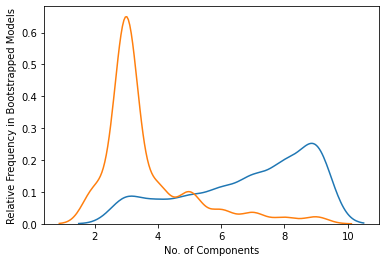

In [ ]:
with sns.color_palette('tab10'):
  sns.distplot(min_est_aic, hist=False, label="AIC")
  sns.distplot(min_est_bic, hist=False, label="BIC")
  plt.xlabel('No. of Components')
  plt.ylabel('Relative Frequency in Bootstrapped Models')
  plt.show()

Based on some [quick reading](https://www.methodology.psu.edu/resources/aic-vs-bic/), it seems that AIC is biased towards more complex models whereas BIC is biased towards less complex models. Although we could evaluate a model at each number of components between 9 (AIC's pick) and 3 (BIC's pick), our initial suspicions already identified 3 populations, and with our sample size, a larger number of components would provide minimal value. Hence, we feel safe selecting 3 components.

We then fit a Gaussian Mixture Model to all of our samples. We can view the predicted components as distinct gaussian's across all of our puffs.


In [9]:
puffs_model = GaussianMixture(3, covariance_type='spherical').fit(puffs.loc[:,'enrichment'][:,np.newaxis])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


We can see the means of the predicted components:


In [10]:
print(puffs_model.means_)
sorted_component_ids = np.argsort(puffs_model.means_, axis=None)

[[22.32277643]
 [-0.23853493]
 [ 5.54435341]]


In [25]:
sorted_component_ids

array([1, 2, 0])

As well as the relative frequencies of those components in our sample:


In [11]:
puffs_model.weights_

array([0.03649579, 0.68775994, 0.27574427])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


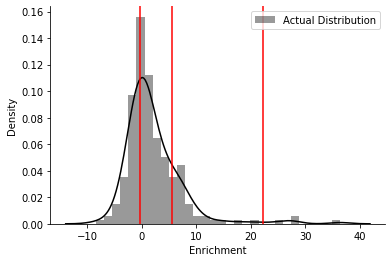

In [12]:
sns.distplot(puffs.loc[:,'enrichment'], hist=True, label='Actual Distribution', color='k')
for mean_val in puffs_model.means_:
    plt.axvline(mean_val,color='r')
plt.ylabel('Density')
plt.xlabel('Enrichment')
plt.legend()
sns.despine()
plt.show()

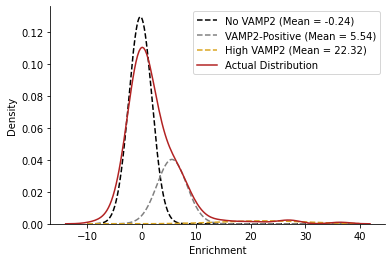

In [23]:
with sns.color_palette(['black','gray','goldenrod','firebrick']):
  fig, ax = plt.subplots(1,1)
  x = np.linspace(-10,40,5000)
  logprobs = puffs_model.score_samples(x.reshape(-1, 1))
  responsibilities = puffs_model.predict_proba(x.reshape(-1, 1))
  pdf = np.exp(logprobs)
  pdf_individual = responsibilities * pdf[:, np.newaxis]
  for idx, name in zip(sorted_component_ids, ['No VAMP2', 'VAMP2-Positive', 'High VAMP2']):
    label = name +' (Mean = ' + '{:.2f}'.format(puffs_model.means_.flat[idx]) + ')'
    ax.plot(x, pdf_individual[:,idx], linestyle='--', label=label)
  sns.kdeplot(puffs.loc[:,'enrichment'], label='Actual Distribution')
  plt.ylabel('Density')
  plt.xlabel('Enrichment')
  plt.legend()
  sns.despine()
  plt.show()

Finally, we can use this model to predict the component membership of each puff we have observed. We can then view the relative fraction of puffs for each receptor coming from a given cluster.


In [33]:
puffs['cluster'] = puffs_model.predict(puffs.loc[:,'enrichment'][:,np.newaxis])
puffs.head()
cluster_names[sorted_component_ids[1]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


'High VAMP2'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


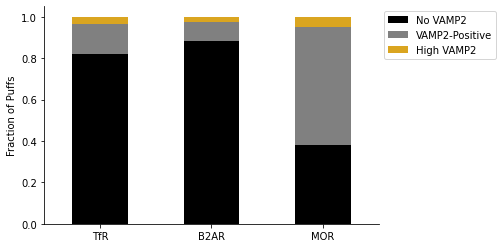

In [36]:
cluster_names = ['No VAMP2', 'VAMP2-Positive', 'High VAMP2']
puffs['cluster'] = puffs_model.predict(puffs.loc[:,'enrichment'][:,np.newaxis])
puffs['cluster'] = [cluster_names[sorted_component_ids.tolist().index(cluster)] for cluster in puffs['cluster'] ]
puffs_by_cluster = puffs.groupby(['cargo','cluster']).agg({'enrichment':'count'})
rel_puffs_by_cluster = puffs_by_cluster.div(puffs.groupby('cargo').agg({'enrichment':'count'}))

with sns.color_palette(['black','gray','goldenrod']):
  (rel_puffs_by_cluster
   .reset_index()
   .pivot(index='cargo',columns='cluster',values='enrichment')
   .loc[['TfR', 'B2AR', 'MOR'],cluster_names]
   .plot.bar(stacked=True))
  plt.ylabel('Fraction of Puffs')
  plt.xlabel('')
  plt.xticks(rotation=0)
  plt.legend(title=None, bbox_to_anchor=[1,1])
  sns.despine()
  plt.show()